# Making Clustered Maps

In [113]:
import json
from datetime import datetime, timedelta
from urllib.request import urlopen

import altair as alt
from altair import datum
import matplotlib.pyplot as plt
import numpy as np
import numpy.polynomial.polynomial as poly
import pandas as pd
from pytz import timezone
import seaborn as sns

from scipy.signal import savgol_filter

import datapane as dp

In [75]:
with open('data/county_json2.json') as f:
    county_json2 = json.load(f)
    
nyt_df = pd.read_csv('data/nyt_df.csv', dtype={'fips':'str'}, parse_dates=['date'])
nyt_df.head()

date     county       state   fips  cases  deaths
0 2020-01-21  Snohomish  Washington  53061      1       0
1 2020-01-22  Snohomish  Washington  53061      1       0
2 2020-01-23  Snohomish  Washington  53061      1       0
3 2020-01-24       Cook    Illinois  17031      1       0
4 2020-01-24  Snohomish  Washington  53061      1       0

In [58]:
nyt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360123 entries, 0 to 360122
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    360123 non-null  datetime64[ns]
 1   county  360123 non-null  object        
 2   state   360123 non-null  object        
 3   fips    360123 non-null  object        
 4   cases   360123 non-null  int64         
 5   deaths  360123 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 16.5+ MB


In [59]:
pop_df_ac = pd.read_csv('data/pop_df_ac.csv', dtype={'fips':'str', 'cluster':'int'})
pop_df_ac.head()

state   county  total_pop   fips   white  black  asian  hispanic  \
0  Alabama  Autauga      55869  01001   41215  11098    646      1671   
1  Alabama  Baldwin     223234  01003  185747  19215   2346     10534   
2  Alabama  Barbour      24686  01005   11235  11807    116      1117   
3  Alabama     Bibb      22394  01007   16663   4719     46       623   
4  Alabama   Blount      57826  01009   50176    872    163      5582   

       area        lon  ...  total_votes  median_income  pop_density  \
0   594.436 -86.641196  ...      24661.0          58786    93.986569   
1  1589.784 -87.723954  ...      94090.0          55962   140.417818   
2   884.876 -85.389245  ...      10390.0          34186    27.897694   
3   622.582 -87.124963  ...       8748.0          45340    35.969559   
4   644.776 -86.569756  ...      25384.0          48695    89.683859   

   per_white  per_black  per_asian  per_hispanic  per_votes_gop  \
0   0.737708   0.198643   0.011563      0.029909       0.324151   
1   0.832073   0.086076   0.010509      0.047188       0.326026   
2   0.455116   0.478287   0.004699      0.045248       0.220003   
3   0.744083   0.210726   0.002054      0.027820       0.300661   
4   0.867707   0.015080   0.002819      0.096531       0.394425   

   per_votes_dem  cluster  
0       0.105747        0  
1       0.082465        1  
2       0.196387        7  
3       0.083683        0  
4       0.037181        4  

[5 rows x 24 columns]

In [60]:
df = nyt_df.merge(pop_df_ac[['fips', 'cluster', 'state', 'county']], on='fips', suffixes=('_x',''))
df = df.drop(['county_x', 'state_x'], axis=1)

df = df.sort_values(by=['date', 'fips'])

print(df.shape)
df.head()

(353573, 7)


date   fips  cases  deaths  cluster       state     county
0   2020-01-21  53061      1       0        2  Washington  Snohomish
1   2020-01-22  53061      1       0        2  Washington  Snohomish
2   2020-01-23  53061      1       0        2  Washington  Snohomish
185 2020-01-24  17031      1       0       15    Illinois       Cook
3   2020-01-24  53061      1       0        2  Washington  Snohomish

In [61]:
clustered = df.groupby(by=['state', 'cluster', 'date'])

df_ac0 = clustered.agg(
    cases=('cases', sum),
    deaths=('deaths', sum),
).reset_index()

df_ac0.head()

state  cluster       date  cases  deaths
0  Alabama        0 2020-03-13      1       0
1  Alabama        0 2020-03-14      1       0
2  Alabama        0 2020-03-15      1       0
3  Alabama        0 2020-03-16      1       0
4  Alabama        0 2020-03-17      2       0

In [62]:
pop_df_ac.columns

Index(['state', 'county', 'total_pop', 'fips', 'white', 'black', 'asian',
       'hispanic', 'area', 'lon', 'lat', 'pop_per_area', 'votes_gop',
       'votes_dem', 'total_votes', 'median_income', 'pop_density', 'per_white',
       'per_black', 'per_asian', 'per_hispanic', 'per_votes_gop',
       'per_votes_dem', 'cluster'],
      dtype='object')

In [63]:
clustered = pop_df_ac.groupby(by=['state', 'cluster'])
wm_pop = lambda x: np.average(x, weights=pop_df_ac.loc[x.index, 'total_pop'])
wm_area = lambda x: np.average(x, weights=pop_df_ac.loc[x.index, 'area'])

pop_df_ac = clustered.agg(
    county=('county', '-'.join),
    total_pop=('total_pop', sum),
    fips=('fips', '-'.join),
    white=('white', sum),
    black=('black', sum),
    asian=('asian', sum),
    hispanic=('hispanic', sum),
    area=('area', sum),
    lon=('lon', wm_area),
    lat=('lat', wm_area),
    votes_gop=('votes_gop', sum),
    votes_dem=('votes_dem', sum),
    total_votes=('total_votes', sum),
    median_income=('median_income', wm_pop)
).reset_index()

pop_df_ac['pop_density'] = pop_df_ac['total_pop'] / pop_df_ac['area']

cols = ['white', 'black', 'asian', 'hispanic', 'total_votes']
for col in cols:
    pop_df_ac['per_' + col] = pop_df_ac[col] / pop_df_ac['total_pop']
    
cols2 = ['votes_gop', 'votes_dem']
for col in cols2:
    pop_df_ac['per_' + col] = pop_df_ac[col] / pop_df_ac['total_votes']
    
pop_df_ac['gop'] = (pop_df_ac['votes_gop'] > pop_df_ac['votes_dem']).astype(int)

pop_df_ac.head()

state  cluster                                             county  \
0  Alabama        0  Autauga-Bibb-Butler-Chilton-Coffee-Coosa-Covin...   
1  Alabama        1                                     Baldwin-Mobile   
2  Alabama        2  Choctaw-Clarke-Conecuh-Dallas-Escambia-Greene-...   
3  Alabama        3                 Limestone-Morgan-Shelby-Tuscaloosa   
4  Alabama        4  Blount-Calhoun-Cherokee-Clay-Cleburne-Cullman-...   

   total_pop                                               fips   white  \
0     689163  01001-01007-01013-01021-01031-01037-01039-0104...  479695   
1     636444                                        01003-01097  419294   
2     262170  01023-01025-01035-01047-01053-01063-01065-0108...  116658   
3     645651                            01083-01103-01117-01125  460205   
4     743955  01009-01015-01019-01027-01029-01043-01049-0105...  610015   

    black  asian  hispanic       area  ...  median_income  pop_density  \
0  160765   6216     26628  10676.902  ...   46758.926074    64.547094   
1  167703  10840     22977   2819.219  ...   49601.966501   225.751884   
2  132624   1224      5250  13409.081  ...   32466.346706    19.551675   
3  124571  10538     37558   3245.958  ...   60349.847682   198.909228   
4   63059   4689     48946   7871.492  ...   44444.611017    94.512578   

   per_white  per_black  per_asian  per_hispanic  per_total_votes  \
0   0.696054   0.233276   0.009020      0.038638         0.420989   
1   0.658807   0.263500   0.017032      0.036102         0.404556   
2   0.444971   0.505870   0.004669      0.020025         0.522935   
3   0.712777   0.192939   0.016322      0.058171         0.418658   
4   0.819962   0.084762   0.006303      0.065792         0.412689   

   per_votes_gop  per_votes_dem  gop  
0       0.725723       0.255196    1  
1       0.636434       0.337265    1  
2       0.464281       0.526776    0  
3       0.690929       0.278309    1  
4       0.805053       0.172519    1  

[5 rows x 25 columns]

In [64]:
df_ac = df_ac0.merge(pop_df_ac, on=['state', 'cluster'], suffixes=('_x',''))
df_ac[['cases_per_100k', 'deaths_per_100k']] = df_ac[['cases', 'deaths']].div(df_ac['total_pop'], axis=0) * 100_000
df_ac = df_ac.sort_values(by=['date', 'fips'])

print(df_ac.shape)
df_ac.head()

(74252, 30)


state  cluster       date  cases  deaths            county  \
70361  Washington        2 2020-01-21      1       0  Island-Snohomish   
70362  Washington        2 2020-01-22      1       0  Island-Snohomish   
70363  Washington        2 2020-01-23      1       0  Island-Snohomish   
23503    Illinois       15 2020-01-24      1       0              Cook   
70364  Washington        2 2020-01-24      1       0  Island-Snohomish   

       total_pop         fips    white    black  ...  per_white  per_black  \
70361     907224  53029-53061   626655    31341  ...   0.690739   0.034546   
70362     907224  53029-53061   626655    31341  ...   0.690739   0.034546   
70363     907224  53029-53061   626655    31341  ...   0.690739   0.034546   
23503    5150233        17031  2162156  1184247  ...   0.419817   0.229940   
70364     907224  53029-53061   626655    31341  ...   0.690739   0.034546   

       per_asian  per_hispanic  per_total_votes  per_votes_gop  per_votes_dem  \
70361   0.111813      0.103764         0.387910       0.382734       0.536225   
70362   0.111813      0.103764         0.387910       0.382734       0.536225   
70363   0.111813      0.103764         0.387910       0.382734       0.536225   
23503   0.077317      0.256160         0.399053       0.214193       0.743758   
70364   0.111813      0.103764         0.387910       0.382734       0.536225   

       gop  cases_per_100k  deaths_per_100k  
70361    0        0.110226              0.0  
70362    0        0.110226              0.0  
70363    0        0.110226              0.0  
23503    0        0.019417              0.0  
70364    0        0.110226              0.0  

[5 rows x 30 columns]

In [65]:
df_ac.to_csv('data/df_ac-no-trends.csv', index=False)

In [66]:
cols = ['cases', 'deaths', 'cases_per_100k', 'deaths_per_100k']

def add_change_cols(df, cols, pre='new_', clip=True):
    df = df.sort_values(by=['date', 'fips'])
    new_cols = [pre + c for c in cols]
    df[new_cols] = df[cols] - df.groupby(by='fips')[cols].shift()
    df[new_cols] = df[new_cols].fillna(0)
    if clip:
        df[new_cols] = df[new_cols].clip(lower=0)
    return (df, new_cols)

def add_savgol_cols(df, cols, window=7):
    def my_savgol(x, w):
        if len(x) >= w:
            return savgol_filter(x, w, 1)
        else:
            new_window = int(np.ceil(len(x) / 2) * 2 - 1)
            if new_window <= 1:
                return x
            else:
                return savgol_filter(x, new_window, 1)
    df = df.sort_values(by=['date', 'fips'])
    cols_d = [c + '_' + str(window) + 'sg' for c in cols]
    df[cols_d] = df.groupby(by='fips')[cols].transform(lambda x: my_savgol(x, window))
    return (df, cols_d)

In [67]:
df_ac, new_cols = add_change_cols(df_ac, cols, pre='new_', clip=True)
df_ac, new_cols_7sg = add_savgol_cols(df_ac, new_cols)
df_ac, new_cols_15sg = add_savgol_cols(df_ac, new_cols, window=15)
df_ac, delta_new_cols = add_change_cols(df_ac, new_cols, pre='delta_', clip=False)
df_ac, delta_new_cols_7sg = add_savgol_cols(df_ac, delta_new_cols)
df_ac, delta_new_cols_15sg = add_savgol_cols(df_ac, delta_new_cols, window=15)

print(df_ac.columns)
df_ac.head()

Index(['state', 'cluster', 'date', 'cases', 'deaths', 'county', 'total_pop',
       'fips', 'white', 'black', 'asian', 'hispanic', 'area', 'lon', 'lat',
       'votes_gop', 'votes_dem', 'total_votes', 'median_income', 'pop_density',
       'per_white', 'per_black', 'per_asian', 'per_hispanic',
       'per_total_votes', 'per_votes_gop', 'per_votes_dem', 'gop',
       'cases_per_100k', 'deaths_per_100k', 'new_cases', 'new_deaths',
       'new_cases_per_100k', 'new_deaths_per_100k', 'new_cases_7sg',
       'new_deaths_7sg', 'new_cases_per_100k_7sg', 'new_deaths_per_100k_7sg',
       'new_cases_15sg', 'new_deaths_15sg', 'new_cases_per_100k_15sg',
       'new_deaths_per_100k_15sg', 'delta_new_cases', 'delta_new_deaths',
       'delta_new_cases_per_100k', 'delta_new_deaths_per_100k',
       'delta_new_cases_7sg', 'delta_new_deaths_7sg',
       'delta_new_cases_per_100k_7sg', 'delta_new_deaths_per_100k_7sg',
       'delta_new_cases_15sg', 'delta_new_deaths_15sg',
       'delta_new_cases_per_1

state  cluster       date  cases  deaths            county  \
70361  Washington        2 2020-01-21      1       0  Island-Snohomish   
70362  Washington        2 2020-01-22      1       0  Island-Snohomish   
70363  Washington        2 2020-01-23      1       0  Island-Snohomish   
23503    Illinois       15 2020-01-24      1       0              Cook   
70364  Washington        2 2020-01-24      1       0  Island-Snohomish   

       total_pop         fips    white    black  ...  \
70361     907224  53029-53061   626655    31341  ...   
70362     907224  53029-53061   626655    31341  ...   
70363     907224  53029-53061   626655    31341  ...   
23503    5150233        17031  2162156  1184247  ...   
70364     907224  53029-53061   626655    31341  ...   

       delta_new_cases_per_100k  delta_new_deaths_per_100k  \
70361                       0.0                        0.0   
70362                       0.0                        0.0   
70363                       0.0                        0.0   
23503                       0.0                        0.0   
70364                       0.0                        0.0   

       delta_new_cases_7sg  delta_new_deaths_7sg  \
70361             0.000000                   0.0   
70362             0.000000                   0.0   
70363             0.000000                   0.0   
23503            -0.178571                   0.0   
70364             0.000000                   0.0   

       delta_new_cases_per_100k_7sg  delta_new_deaths_per_100k_7sg  \
70361                      0.000000                            0.0   
70362                      0.000000                            0.0   
70363                      0.000000                            0.0   
23503                     -0.003467                            0.0   
70364                      0.000000                            0.0   

       delta_new_cases_15sg  delta_new_deaths_15sg  \
70361                 0.000                    0.0   
70362                 0.000                    0.0   
70363                 0.000                    0.0   
23503                 0.025                    0.0   
70364                 0.000                    0.0   

       delta_new_cases_per_100k_15sg  delta_new_deaths_per_100k_15sg  
70361                       0.000000                             0.0  
70362                       0.000000                             0.0  
70363                       0.000000                             0.0  
23503                       0.000485                             0.0  
70364                       0.000000                             0.0  

[5 rows x 54 columns]

In [68]:
df_ac.to_csv('data/df_ac.csv', index=False)

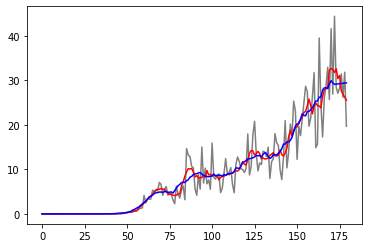

In [69]:
county = 'Los Angeles'
temp_df = df_ac[df_ac['county'] == county]
plt.plot(np.arange(len(temp_df)), 'new_cases_per_100k', data=temp_df, color='gray')
plt.plot(np.arange(len(temp_df)), 'new_cases_per_100k_7sg', data=temp_df, color='red')
plt.plot(np.arange(len(temp_df)), 'new_cases_per_100k_15sg', data=temp_df, color='blue')

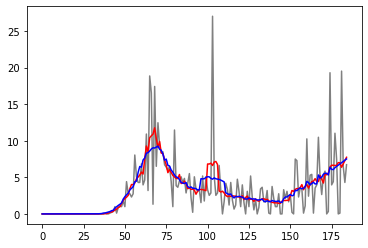

In [72]:
county = 'Island-Snohomish'
temp_df = df_ac[df_ac['county'] == county]
plt.plot(np.arange(len(temp_df)), 'new_cases_per_100k', data=temp_df, color='gray')
plt.plot(np.arange(len(temp_df)), 'new_cases_per_100k_7sg', data=temp_df, color='red')
plt.plot(np.arange(len(temp_df)), 'new_cases_per_100k_15sg', data=temp_df, color='blue')

In [73]:
df_ac['days'] = ((df_ac['date'] - df_ac['date'].min()) / np.timedelta64(1, 'D')).astype('int')

In [76]:
la = timezone('US/Pacific')
last = df_ac['date'].max()
df_slice = df_ac[df_ac['date'] == last]
df_slice.head()

state  cluster       date  cases  deaths  \
132   Alabama        0 2020-07-23   9463     241   
264   Alabama        1 2020-07-23   9290     193   
1039  Alabama        7 2020-07-23   3027      64   
652   Alabama        4 2020-07-23  10314      92   
390   Alabama        2 2020-07-23   6630     180   

                                                 county  total_pop  \
132   Autauga-Bibb-Butler-Chilton-Coffee-Coosa-Covin...     689163   
264                                      Baldwin-Mobile     636444   
1039             Barbour-Bullock-Chambers-Macon-Russell     144070   
652   Blount-Calhoun-Cherokee-Clay-Cleburne-Cullman-...     743955   
390   Choctaw-Clarke-Conecuh-Dallas-Escambia-Greene-...     262170   

                                                   fips   white   black  ...  \
132   01001-01007-01013-01021-01031-01037-01039-0104...  479695  160765  ...   
264                                         01003-01097  419294  167703  ...   
1039                      01005-01011-01017-01087-01113   61223   72250  ...   
652   01009-01015-01019-01027-01029-01043-01049-0105...  610015   63059  ...   
390   01023-01025-01035-01047-01053-01063-01065-0108...  116658  132624  ...   

      delta_new_deaths_per_100k  delta_new_cases_7sg  delta_new_deaths_7sg  \
132                   -1.015725            33.357143              1.321429   
264                   -0.785615           168.321429              0.357143   
1039                  -2.776428             9.250000             -0.392857   
652                    0.268833            52.250000              0.464286   
390                   -1.907159            24.071429              0.428571   

      delta_new_cases_per_100k_7sg  delta_new_deaths_per_100k_7sg  \
132                       4.840240                       0.191744   
264                      26.447170                       0.056115   
1039                      6.420490                      -0.272685   
652                       7.023274                       0.062408   
390                       9.181611                       0.163471   

      delta_new_cases_15sg  delta_new_deaths_15sg  \
132              14.241667               1.158333   
264              85.016667              -0.275000   
1039             -0.858333              -0.108333   
652              16.183333               0.366667   
390               4.091667               0.358333   

      delta_new_cases_per_100k_15sg  delta_new_deaths_per_100k_15sg  days  
132                        2.066516                        0.168078   184  
264                       13.358075                       -0.043209   184  
1039                      -0.595775                       -0.075195   184  
652                        2.175311                        0.049286   184  
390                        1.560692                        0.136680   184  

[5 rows x 55 columns]

In [77]:
# https://stackoverflow.com/a/55950538
county_json_alt = alt.InlineData(county_json2, format=alt.DataFormat(property='features',type='json'))

In [78]:
def cov(x, y, w):
    return np.sum(w * (x - np.average(x, weights=w)) * (y - np.average(x, weights=w))) / np.sum(w)

def corr(x, y, w):
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

In [137]:
df_slice.columns

Index(['state', 'cluster', 'date', 'cases', 'deaths', 'county', 'total_pop',
       'fips', 'white', 'black', 'asian', 'hispanic', 'area', 'lon', 'lat',
       'votes_gop', 'votes_dem', 'total_votes', 'median_income', 'pop_density',
       'per_white', 'per_black', 'per_asian', 'per_hispanic',
       'per_total_votes', 'per_votes_gop', 'per_votes_dem', 'cases_per_100k',
       'deaths_per_100k', 'new_cases', 'new_deaths', 'new_cases_per_100k',
       'new_deaths_per_100k', 'new_cases_7sg', 'new_deaths_7sg',
       'new_cases_per_100k_7sg', 'new_deaths_per_100k_7sg', 'new_cases_15sg',
       'new_deaths_15sg', 'new_cases_per_100k_15sg',
       'new_deaths_per_100k_15sg', 'delta_new_cases', 'delta_new_deaths',
       'delta_new_cases_per_100k', 'delta_new_deaths_per_100k',
       'delta_new_cases_7sg', 'delta_new_deaths_7sg',
       'delta_new_cases_per_100k_7sg', 'delta_new_deaths_per_100k_7sg',
       'delta_new_cases_15sg', 'delta_new_deaths_15sg',
       'delta_new_cases_per_100k_15s

In [ ]:
df_slice2.groupby(by='gop')['fips'].count()

In [115]:
x_cols = ['pop_density', 'per_white', 'per_black', 'per_asian', 'per_hispanic', 'per_total_votes', 'per_votes_gop', 'median_income']
y_cols = ['pop_density', 'per_white', 'per_black', 'per_asian', 'per_hispanic', 'per_total_votes', 'per_votes_gop', 'median_income', 'cases_per_100k', 'deaths_per_100k', 'new_cases_per_100k_15sg', 'new_deaths_per_100k_15sg', 'delta_new_cases_per_100k_15sg', 'delta_new_deaths_per_100k_15sg']
w_col = 'total_pop'

Text(0.5, 0.98, 'covid correlation heatmap')

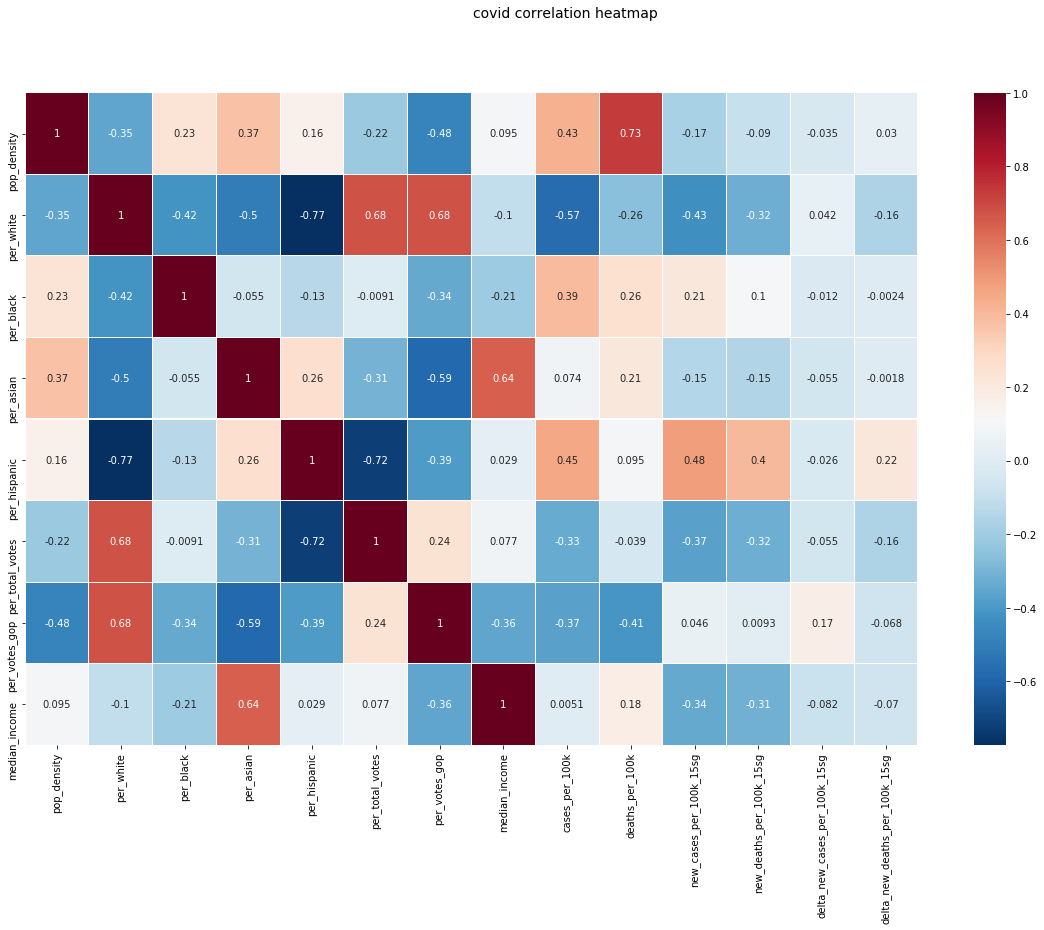

In [119]:
wcm = pd.DataFrame(index=x_cols, columns=y_cols)

for x in x_cols:
    for y in y_cols:
        wcm.loc[x, y] = corr(df_slice[x], df_slice[y], df_slice[w_col])
        
fig, (ax) = plt.subplots(1, 1, figsize=(20,12))

hm = sns.heatmap(np.array(wcm,dtype='float64'), 
                 ax=ax,
                 yticklabels=wcm.index,
                 xticklabels=wcm.columns,
                 cmap="RdBu_r",
                 annot=True, 
#                  fmt='.1f',
                 linewidths=.05)

# fig.subplots_adjust(top=0.93)
fig.suptitle('covid correlation heatmap', 
              fontsize=14)

# Cases per 100k vs. Population Density (Δ new cases)

In [79]:
chart_title='Case Density vs. Population Density'
x_col='pop_density'
x_scale='sqrt'
x_title='pop per sq mi'
y_col='cases_per_100k'
y_scale='sqrt'
y_title='cases per 100k'
s_col='cases'
s_title='total cases'
c_col='delta_new_cases_per_100k_15sg'
c_title=u'Δ new cases (15d window)'
c_scheme='blueorange'
w_col='total_pop'
split=False
line=True

data = df_slice.sort_values(by=c_col).copy()

smax = np.max(data[s_col])
smax = smax + (-smax) % 10

chart = alt.Chart(data).mark_circle(
    stroke='black',
    strokeWidth=0.25,
).properties(
    title=chart_title,
    width=720,
    height=480
).encode(
    x=alt.X(
        x_col + ':Q',
        scale=alt.Scale(type=x_scale),
        title=x_title
    ),
    y=alt.Y(
        y_col + ':Q',
        scale=alt.Scale(type=y_scale),
        title=y_title
    ),
    size=alt.Size(
        s_col + ':Q',
        scale=alt.Scale(
            domain=[1,smax],
            range=[10,2000]
        ),
        title=s_title
    ),
    color=alt.Color(
        c_col + ':Q',
        scale=alt.Scale(
            scheme=c_scheme,
            domain=[np.percentile(data[c_col], 0.5), np.percentile(data[c_col], 99.5)],
            domainMid=0,
        ),
        sort='ascending',
        title=c_title
    ),
    tooltip=[
        'state:N', 'county:N',
        alt.Tooltip(
            'cases:Q',
            title='total cases',
        ), 
        alt.Tooltip(
            'cases_per_100k:Q',
            format='.1f',
            title='cases per 100k',
        ), 
        alt.Tooltip(
            'pop_density:Q',
            format='.1f',
            title='pop per sq mi',
        ), 
        alt.Tooltip(
            y_col + ':Q',
            format='.1f',
            title=y_title
        ),
        alt.Tooltip(
            x_col + ':Q',
            format='.1f',
            title=x_title
        )
    ]
)

chart

alt.Chart(...)

# Cases per 100k vs. Median Income (Δ new cases)

In [80]:
chart_title='Case Density vs. Median Income'
x_col='median_income'
x_scale='linear'
x_title='median income'
y_col='cases_per_100k'
y_scale='sqrt'
y_title='cases per 100k'
s_col='cases'
s_title='total cases'
c_col='delta_new_cases_per_100k_15sg'
c_title=u'Δ new cases (15d window)'
c_scheme='blueorange'
w_col='total_pop'
split=False
line=True

data = df_slice.sort_values(by=c_col).copy()

smax = np.max(data[s_col])
smax = smax + (-smax) % 10

chart = alt.Chart(data).mark_circle(
    stroke='black',
    strokeWidth=0.25,
).properties(
    title=chart_title,
    width=720,
    height=480
).encode(
    x=alt.X(
        x_col + ':Q',
        scale=alt.Scale(type=x_scale),
        title=x_title
    ),
    y=alt.Y(
        y_col + ':Q',
        scale=alt.Scale(type=y_scale),
        title=y_title
    ),
    size=alt.Size(
        s_col + ':Q',
        scale=alt.Scale(
            domain=[1,smax],
            range=[10,2000]
        ),
        title=s_title
    ),
    color=alt.Color(
        c_col + ':Q',
        scale=alt.Scale(
            scheme=c_scheme,
            domain=[np.percentile(data[c_col], 0.5), np.percentile(data[c_col], 99.5)],
            domainMid=0,
        ),
        sort='ascending',
        title=c_title
    ),
    tooltip=[
        'state:N', 'county:N',
        alt.Tooltip(
            'cases:Q',
            title='total cases',
        ), 
        alt.Tooltip(
            'cases_per_100k:Q',
            format='.1f',
            title='cases per 100k',
        ), 
        alt.Tooltip(
            'pop_density:Q',
            format='.1f',
            title='pop per sq mi',
        ), 
        alt.Tooltip(
            y_col + ':Q',
            format='.1f',
            title=y_title
        ),
        alt.Tooltip(
            x_col + ':Q',
            format='.1f',
            title=x_title
        )
    ]
)

chart

alt.Chart(...)

# Δ New Cases per 100k vs. Population Density (percent GOP)

In [112]:
chart_title='New Case Density vs. Population Density'
x_col='pop_density'
x_scale='sqrt'
x_title='population density'
y_col='delta_new_cases_per_100k_15sg'
y_scale='sqrt'
y_title='new cases per 100k'
s_col='cases'
s_title='total cases'
c_col='per_votes_gop'
c_title='% votes GOP'
c_scheme='redblue'
w_col='total_pop'
split=False
line=True

data = df_slice.sort_values(by=c_col).copy()

smax = np.max(data[s_col])
smax = smax + (-smax) % 10

chart = alt.Chart(data).mark_circle(
    stroke='black',
    strokeWidth=0.25,
).properties(
    title=chart_title,
    width=720,
    height=480
).encode(
    x=alt.X(
        x_col + ':Q',
        scale=alt.Scale(type=x_scale),
        title=x_title
    ),
    y=alt.Y(
        y_col + ':Q',
        scale=alt.Scale(type=y_scale),
        title=y_title
    ),
    size=alt.Size(
        s_col + ':Q',
        scale=alt.Scale(
            domain=[1,smax],
            range=[10,2000]
        ),
        title=s_title
    ),
    color=alt.Color(
        c_col + ':Q',
        scale=alt.Scale(
            scheme=c_scheme,
#             domain=[np.percentile(data[c_col], 1), np.percentile(data[c_col], 99)],
            domainMid=0.5,
        ),
        sort='descending',
        title=c_title
    ),
    tooltip=[
        'state:N', 'county:N',
        alt.Tooltip(
            'cases:Q',
            title='total cases',
        ), 
        alt.Tooltip(
            'cases_per_100k:Q',
            format='.1f',
            title='cases per 100k',
        ), 
        alt.Tooltip(
            'pop_density:Q',
            format='.1f',
            title='pop per sq mi',
        ), 
        alt.Tooltip(
            y_col + ':Q',
            format='.1f',
            title=y_title
        ),
        alt.Tooltip(
            x_col + ':Q',
            format='.1f',
            title=x_title
        )
    ]
)

pfit0 = poly.polyfit(data[data['gop']==0][x_col], data[data['gop']==0][y_col], 1, w=data[data['gop']==0][w_col])
pfit1 = poly.polyfit(data[data['gop']==1][x_col], data[data['gop']==1][y_col], 1, w=data[data['gop']==1][w_col])
fit0 = poly.polyval(np.unique(data[data['gop']==0][x_col]), pfit0)
fit1 = poly.polyval(np.unique(data[data['gop']==1][x_col]), pfit1)
line_df0 = pd.DataFrame({
  'x': np.unique(data[data['gop']==0][x_col]),
  'y': fit0
})
line_df1 = pd.DataFrame({
  'x': np.unique(data[data['gop']==1][x_col]),
  'y': fit1
})
line0 = alt.Chart(line_df0).mark_line(color='darkblue').encode(
    x='x:Q',
    y='y:Q'
).transform_calculate(label='datum.y + "inches"')
line1 = alt.Chart(line_df1).mark_line(color='firebrick').encode(
    x='x:Q',
    y='y:Q'
)

chart + line0 + line1

alt.LayerChart(...)

In [82]:
chart_title='New Case Density vs. Population Density'
x_col='per_votes_gop'
x_scale='linear'
x_title='% votes GOP'
y_col='new_cases_per_100k_15sg'
y_scale='sqrt'
y_title='new cases per 100k'
s_col='cases'
s_title='total cases'
c_col='per_votes_gop'
c_title='% votes GOP'
c_scheme='redblue'
w_col='total_pop'
split=False
line=True

data = df_slice.sort_values(by=c_col).copy()

smax = np.max(data[s_col])
smax = smax + (-smax) % 10

chart = alt.Chart(data).mark_circle(
    stroke='black',
    strokeWidth=0.25,
).properties(
    title=chart_title,
    width=720,
    height=480
).encode(
    x=alt.X(
        x_col + ':Q',
        scale=alt.Scale(type=x_scale),
        title=x_title
    ),
    y=alt.Y(
        y_col + ':Q',
        scale=alt.Scale(type=y_scale),
        title=y_title
    ),
    size=alt.Size(
        s_col + ':Q',
        scale=alt.Scale(
            domain=[1,smax],
            range=[10,2000]
        ),
        title=s_title
    ),
    color=alt.Color(
        c_col + ':Q',
        scale=alt.Scale(
            scheme=c_scheme,
#             domain=[np.percentile(data[c_col], 1), np.percentile(data[c_col], 99)],
            domainMid=0.5,
        ),
        sort='descending',
        title=c_title
    ),
    tooltip=[
        'state:N', 'county:N',
        alt.Tooltip(
            'cases:Q',
            title='total cases',
        ), 
        alt.Tooltip(
            'cases_per_100k:Q',
            format='.1f',
            title='cases per 100k',
        ), 
        alt.Tooltip(
            'pop_density:Q',
            format='.1f',
            title='pop per sq mi',
        ), 
        alt.Tooltip(
            y_col + ':Q',
            format='.1f',
            title=y_title
        ),
        alt.Tooltip(
            x_col + ':Q',
            format='.1f',
            title=x_title
        )
    ]
)

pfit0 = poly.polyfit(data[data['gop']==0][x_col], data[data['gop']==0][y_col], 1, w=data[data['gop']==0][w_col])
pfit1 = poly.polyfit(data[data['gop']==1][x_col], data[data['gop']==1][y_col], 1, w=data[data['gop']==1][w_col])
fit0 = poly.polyval(np.unique(data[data['gop']==0][x_col]), pfit0)
fit1 = poly.polyval(np.unique(data[data['gop']==1][x_col]), pfit1)
line_df0 = pd.DataFrame({
  'x': np.unique(data[data['gop']==0][x_col]),
  'y': fit0
})
line_df1 = pd.DataFrame({
  'x': np.unique(data[data['gop']==1][x_col]),
  'y': fit1
})
line0 = alt.Chart(line_df0).mark_line(color='darkblue').encode(
    x='x:Q',
    y='y:Q'
).transform_calculate(label='datum.y + "inches"')
line1 = alt.Chart(line_df1).mark_line(color='firebrick').encode(
    x='x:Q',
    y='y:Q'
)


chart + line0 + line1

alt.LayerChart(...)

In [83]:
chart_title='Case Density vs. Population Density'
x_col='per_votes_gop'
x_scale='linear'
x_title='% votes GOP'
y_col='cases_per_100k'
y_scale='sqrt'
y_title='cases per 100k'
s_col='cases'
s_title='total cases'
c_col='per_votes_gop'
c_title='% votes GOP'
c_scheme='redblue'
w_col='total_pop'
split=False
line=True

data = df_slice.sort_values(by=c_col).copy()

smax = np.max(data[s_col])
smax = smax + (-smax) % 10

chart = alt.Chart(data).mark_circle(
    stroke='black',
    strokeWidth=0.25,
).properties(
    title=chart_title,
    width=720,
    height=480
).encode(
    x=alt.X(
        x_col + ':Q',
        scale=alt.Scale(type=x_scale),
        title=x_title
    ),
    y=alt.Y(
        y_col + ':Q',
        scale=alt.Scale(type=y_scale),
        title=y_title
    ),
    size=alt.Size(
        s_col + ':Q',
        scale=alt.Scale(
            domain=[1,smax],
            range=[10,2000]
        ),
        title=s_title
    ),
    color=alt.Color(
        c_col + ':Q',
        scale=alt.Scale(
            scheme=c_scheme,
#             domain=[np.percentile(data[c_col], 1), np.percentile(data[c_col], 99)],
            domainMid=0.5,
        ),
        sort='descending',
        title=c_title
    ),
    tooltip=[
        'state:N', 'county:N',
        alt.Tooltip(
            'cases:Q',
            title='total cases',
        ), 
        alt.Tooltip(
            'cases_per_100k:Q',
            format='.1f',
            title='cases per 100k',
        ), 
        alt.Tooltip(
            'pop_density:Q',
            format='.1f',
            title='pop per sq mi',
        ), 
        alt.Tooltip(
            y_col + ':Q',
            format='.1f',
            title=y_title
        ),
        alt.Tooltip(
            x_col + ':Q',
            format='.1f',
            title=x_title
        )
    ]
)

pfit0 = poly.polyfit(data[x_col], data[y_col], 1, w=data[w_col])

fit0 = poly.polyval(np.unique(data[x_col]), pfit0)

line_df0 = pd.DataFrame({
  'x': np.unique(data[x_col]),
  'y': fit0
})

line0 = alt.Chart(line_df0).mark_line(color='black').encode(
    x='x:Q',
    y='y:Q'
).transform_calculate()


chart + line0

alt.LayerChart(...)

# New Cases per 100k vs. Percent GOP

In [84]:
chart_title='New Cases per 100k vs. Percent GOP'
x_col='per_votes_gop'
x_scale='linear'
x_title='% votes GOP'
y_col='new_cases_per_100k_15sg'
y_scale='sqrt'
y_title='new cases per 100k'
s_col='cases'
s_title='total cases'
c_col='per_votes_gop'
c_title='% votes GOP'
c_scheme='redblue'
w_col='total_pop'
split=False
line=True

data = df_slice.sort_values(by=c_col).copy()

smax = np.max(data[s_col])
smax = smax + (-smax) % 10

chart = alt.Chart(data).mark_circle(
    stroke='black',
    strokeWidth=0.25,
).properties(
    title=chart_title,
    width=720,
    height=480
).encode(
    x=alt.X(
        x_col + ':Q',
        scale=alt.Scale(type=x_scale),
        title=x_title
    ),
    y=alt.Y(
        y_col + ':Q',
        scale=alt.Scale(type=y_scale),
        title=y_title
    ),
    size=alt.Size(
        s_col + ':Q',
        scale=alt.Scale(
            domain=[1,smax],
            range=[10,2000]
        ),
        title=s_title
    ),
    color=alt.Color(
        c_col + ':Q',
        scale=alt.Scale(
            scheme=c_scheme,
#             domain=[np.percentile(data[c_col], 1), np.percentile(data[c_col], 99)],
            domainMid=0.5,
        ),
        sort='descending',
        title=c_title
    ),
    tooltip=[
        'state:N', 'county:N',
        alt.Tooltip(
            'cases:Q',
            title='total cases',
        ), 
        alt.Tooltip(
            'cases_per_100k:Q',
            format='.1f',
            title='cases per 100k',
        ), 
        alt.Tooltip(
            'pop_density:Q',
            format='.1f',
            title='pop per sq mi',
        ), 
        alt.Tooltip(
            y_col + ':Q',
            format='.1f',
            title=y_title
        ),
        alt.Tooltip(
            x_col + ':Q',
            format='.1f',
            title=x_title
        )
    ]
)

pfit0 = poly.polyfit(data[x_col], data[y_col], 1)

fit0 = poly.polyval(np.unique(data[x_col]), pfit0)

line_df0 = pd.DataFrame({
  'x': np.unique(data[x_col]),
  'y': fit0
})

line0 = alt.Chart(line_df0).mark_line(color='black').encode(
    x='x:Q',
    y='y:Q'
).transform_calculate()


chart + line0

alt.LayerChart(...)

In [116]:
chart_title='Change in New Cases per 100k vs. Percent GOP'
x_col='per_votes_gop'
x_scale='linear'
x_title='% votes GOP'
y_col='delta_new_cases_per_100k_15sg'
y_scale='sqrt'
y_title=u'Δ new cases per 100k'
s_col='cases'
s_title='total cases'
c_col='per_votes_gop'
c_title='% votes GOP'
c_scheme='redblue'
w_col='total_pop'
split=False
line=True

data = df_slice.sort_values(by=c_col).copy()

smax = np.max(data[s_col])
smax = smax + (-smax) % 10

chart = alt.Chart(data).mark_circle(
    stroke='black',
    strokeWidth=0.25,
).properties(
    title=chart_title,
    width=720,
    height=480
).encode(
    x=alt.X(
        x_col + ':Q',
        scale=alt.Scale(type=x_scale),
        title=x_title
    ),
    y=alt.Y(
        y_col + ':Q',
        scale=alt.Scale(type=y_scale),
        title=y_title
    ),
    size=alt.Size(
        s_col + ':Q',
        scale=alt.Scale(
            domain=[1,smax],
            range=[10,2000]
        ),
        title=s_title
    ),
    color=alt.Color(
        c_col + ':Q',
        scale=alt.Scale(
            scheme=c_scheme,
#             domain=[np.percentile(data[c_col], 1), np.percentile(data[c_col], 99)],
            domainMid=0.5,
        ),
        sort='descending',
        title=c_title
    ),
    tooltip=[
        'state:N', 'county:N',
        alt.Tooltip(
            'cases:Q',
            title='total cases',
        ), 
        alt.Tooltip(
            'cases_per_100k:Q',
            format='.1f',
            title='cases per 100k',
        ), 
        alt.Tooltip(
            'pop_density:Q',
            format='.1f',
            title='pop per sq mi',
        ), 
        alt.Tooltip(
            y_col + ':Q',
            format='.1f',
            title=y_title
        ),
        alt.Tooltip(
            x_col + ':Q',
            format='.1f',
            title=x_title
        )
    ]
)

pfit0 = poly.polyfit(data[x_col], data[y_col], 1)

fit0 = poly.polyval(np.unique(data[x_col]), pfit0)

line_df0 = pd.DataFrame({
  'x': np.unique(data[x_col]),
  'y': fit0
})

line0 = alt.Chart(line_df0).mark_line(color='black').encode(
    x='x:Q',
    y='y:Q'
).transform_calculate()


chart + line0

r = dp.Report(dp.Plot(chart + line0))
r.publish(name='delta-new-cases-gop', open=True, visibility='PUBLIC')

In [105]:
chart_title='Change in New Cases per 100k vs. New Cases per 100k'
x_col='new_cases_per_100k_15sg'
x_scale='linear'
x_title='new cases per 100k'
y_col='delta_new_cases_per_100k_15sg'
y_scale='linear'
y_title=u'Δ new cases per 100k'
s_col='cases'
s_title='total cases'
c_col='per_votes_gop'
c_title='% votes GOP'
c_scheme='redblue'
w_col='total_pop'
split=False
line=True

data = df_slice.sort_values(by=c_col).copy()

smax = np.max(data[s_col])
smax = smax + (-smax) % 10

chart = alt.Chart(data).mark_circle(
    stroke='black',
    strokeWidth=0.25,
).properties(
    title=chart_title,
    width=720,
    height=480
).encode(
    x=alt.X(
        x_col + ':Q',
        scale=alt.Scale(type=x_scale),
        title=x_title
    ),
    y=alt.Y(
        y_col + ':Q',
        scale=alt.Scale(type=y_scale),
        title=y_title
    ),
    size=alt.Size(
        s_col + ':Q',
        scale=alt.Scale(
            domain=[1,smax],
            range=[10,2000]
        ),
        title=s_title
    ),
    color=alt.Color(
        c_col + ':Q',
        scale=alt.Scale(
            scheme=c_scheme,
#             domain=[np.percentile(data[c_col], 1), np.percentile(data[c_col], 99)],
            domainMid=0.5,
        ),
        sort='descending',
        title=c_title
    ),
    tooltip=[
        'state:N', 'county:N',
        alt.Tooltip(
            'cases:Q',
            title='total cases',
        ), 
        alt.Tooltip(
            'cases_per_100k:Q',
            format='.1f',
            title='cases per 100k',
        ), 
        alt.Tooltip(
            'pop_density:Q',
            format='.1f',
            title='pop per sq mi',
        ), 
        alt.Tooltip(
            y_col + ':Q',
            format='.1f',
            title=y_title
        ),
        alt.Tooltip(
            x_col + ':Q',
            format='.1f',
            title=x_title
        )
    ]
)

chart_invis = alt.Chart(data).mark_point(
    opacity=0
).encode(
    x=alt.X(
        x_col + ':Q',
    ),
    y=alt.Y(
        y_col + ':Q',
    )
)

line0 = chart_invis.transform_filter(
    (datum.gop == 0)
).transform_regression(
    'new_cases_per_100k_15sg', 
    'delta_new_cases_per_100k_15sg',
    method='linear'
).mark_line(color='darkblue')

line1 = chart_invis.transform_filter(
    (datum.gop == 1)
).transform_regression(
    'new_cases_per_100k_15sg', 
    'delta_new_cases_per_100k_15sg',
    method='linear'
).mark_line(color='firebrick')


chart + line0 + line1

alt.LayerChart(...)

In [89]:
df_ac['days'].max()

184

In [ ]:
chart_title='Change in New Cases per 100k vs. New Cases per 100k'
x_col='new_cases_per_100k_15sg'
x_scale='linear'
x_title='new cases per 100k'
y_col='delta_new_cases_per_100k_15sg'
y_scale='linear'
y_title=u'Δ new cases per 100k'
s_col='cases'
s_title='total cases'
c_col='per_votes_gop'
c_title='% votes GOP'
c_scheme='redblue'
w_col='total_pop'
split=False
line=True

data = df_ac.sort_values(by=c_col).copy()

smax = np.max(data[s_col])
smax = smax + (-smax) % 10

select_week = alt.selection_single(
    name='select', fields=['days'], init={'days': data['days'].max()},
    bind=alt.binding_range(min=data['days'].max()%7, max=data['days'].max(), step=7)
)

chart = alt.Chart(data).mark_circle(
    stroke='black',
    strokeWidth=0.25,
).properties(
    title=chart_title,
    width=720,
    height=480
).encode(
    x=alt.X(
        x_col + ':Q',
        scale=alt.Scale(type=x_scale),
        title=x_title
    ),
    y=alt.Y(
        y_col + ':Q',
        scale=alt.Scale(type=y_scale),
        title=y_title
    ),
    size=alt.Size(
        s_col + ':Q',
        scale=alt.Scale(
            domain=[1,smax],
            range=[10,2000]
        ),
        title=s_title
    ),
    color=alt.Color(
        c_col + ':Q',
        scale=alt.Scale(
            scheme=c_scheme,
#             domain=[np.percentile(data[c_col], 1), np.percentile(data[c_col], 99)],
            domainMid=0.5,
            range=[0,1]
        ),
        sort='descending',
        title=c_title
    ),
    tooltip=[
        'state:N', 'county:N',
        alt.Tooltip(
            'cases:Q',
            title='total cases',
        ), 
        alt.Tooltip(
            'cases_per_100k:Q',
            format='.1f',
            title='cases per 100k',
        ), 
        alt.Tooltip(
            'pop_density:Q',
            format='.1f',
            title='pop per sq mi',
        ), 
        alt.Tooltip(
            y_col + ':Q',
            format='.1f',
            title=y_title
        ),
        alt.Tooltip(
            x_col + ':Q',
            format='.1f',
            title=x_title
        )
    ]
).add_selection(select_week).transform_filter(select_week)

# pfit0 = poly.polyfit(data[data['gop']==0][x_col], data[data['gop']==0][y_col], 1)
# pfit1 = poly.polyfit(data[data['gop']==1][x_col], data[data['gop']==1][y_col], 1)
# fit0 = poly.polyval(np.unique(data[data['gop']==0][x_col]), pfit0)
# fit1 = poly.polyval(np.unique(data[data['gop']==1][x_col]), pfit1)
# line_df0 = pd.DataFrame({
#   'x': np.unique(data[data['gop']==0][x_col]),
#   'y': fit0
# })
# line_df1 = pd.DataFrame({
#   'x': np.unique(data[data['gop']==1][x_col]),
#   'y': fit1
# })
# line0 = alt.Chart(line_df0).mark_line(color='darkblue').encode(
#     x='x:Q',
#     y='y:Q'
# ).add_selection(select_week).transform_filter(select_week)
# line1 = alt.Chart(line_df1).mark_line(color='firebrick').encode(
#     x='x:Q',
#     y='y:Q'
# ).add_selection(select_week).transform_filter(select_week)


chart